# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Partho Protim | Das | Partho | 5 | 25% |
| Member 2: | Rony | Paul | Rony | 5 | 25% |
| Member 3: | Shakil | Ahmed | Shakil | 5 | 25% |
| Member 4: | Kajal Deb | Nath | Kajal | 5 | 25% |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

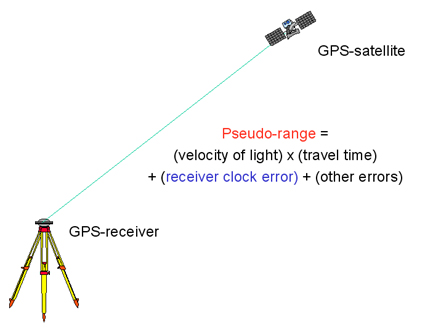

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df_pseudorange = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Mounted at /content/drive


Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [ ]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [ ]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [ ]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [ ]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    # Calculate distances to each satellite position from the receiver
    predicted_pseudorange = euclidean_norm(r_pos, s_pos) + cdT
    residuals = pseudorange - predicted_pseudorange
    L = np.sum(residuals ** 2)  # Sum of squared residuals
    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [ ]:
def gradient(r_pos, cdT, s_pos, pseudorange):
    grad = np.zeros(4)  # Initialize gradient array with 4 elements

    for sat_pos, observed_pseudo in zip(s_pos, pseudorange):
        # Predicted pseudorange is the distance plus clock offset
        distance = euclidean_norm(r_pos, np.array([sat_pos]))[0]  # Distance from r_pos to current satellite
        predicted_pseudorange = distance + cdT

        # Compute residual
        residual = observed_pseudo - predicted_pseudorange

        # Avoid division by zero by checking distance
        if distance != 0:
            grad[0] -= 2 * residual * (r_pos[0] - sat_pos[0]) / distance
            grad[1] -= 2 * residual * (r_pos[1] - sat_pos[1]) / distance
            grad[2] -= 2 * residual * (r_pos[2] - sat_pos[2]) / distance

        # Gradient component for clock offset (cdT)
        grad[3] -= 2 * residual

    return grad


### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [ ]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.01, max_iters=100000, tolerance=1e-6):
     #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

       # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)

          # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

         # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [ ]:
optimized_params = gradient_descent(pseudorange, sat_pos)

# Calculate final position errors of receiver
final_position_errors = optimized_params[:3] - GroundTruth

# print the mentioned metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params)
print("Final Position Errors of Receiver (x_r, y_r, z_r):", final_position_errors)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", cost_function(optimized_params[:3], optimized_params[3], sat_pos, pseudorange))
print("Final Gradient Values:", gradient(optimized_params[:3], optimized_params[3], sat_pos, pseudorange))


Converged !
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162954e+06  4.95248542e+06  6.46523154e+00]
Final Position Errors of Receiver (x_r, y_r, z_r): [-3.06414102 -2.35598329  3.80119585]
Number of Steps Taken for Convergence: 0
Final Cost Value: 6.19709343841564
Final Gradient Values: [ 0.00048759  0.0027168  -0.00834987 -0.00473382]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

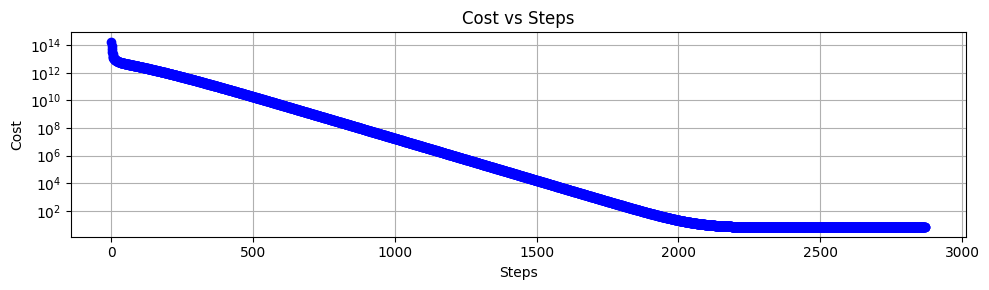

The plot illustrates a downward trend in cost as the number of steps increases, showing that the optimization algorithm is converging.
At first, the cost drops quickly, indicating effective adjustments to the receiver's position and clock offset.
As the steps progress, the decrease in cost becomes less pronounced, which is common in optimization as it nears the minimum.
The final steady cost value suggests the algorithm has reached an optimal solution.


In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
ax.semilogy(arr_cost, marker='o', linestyle='-', color='b')
ax.set_xlabel('Steps')
ax.set_ylabel('Cost')
ax.set_title('Cost vs Steps')

ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
text = (
    "The plot illustrates a downward trend in cost as the number of steps increases, showing that the optimization algorithm is converging.\n"
    "At first, the cost drops quickly, indicating effective adjustments to the receiver's position and clock offset.\n"
    "As the steps progress, the decrease in cost becomes less pronounced, which is common in optimization as it nears the minimum.\n"
    "The final steady cost value suggests the algorithm has reached an optimal solution."
)

print(text)

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

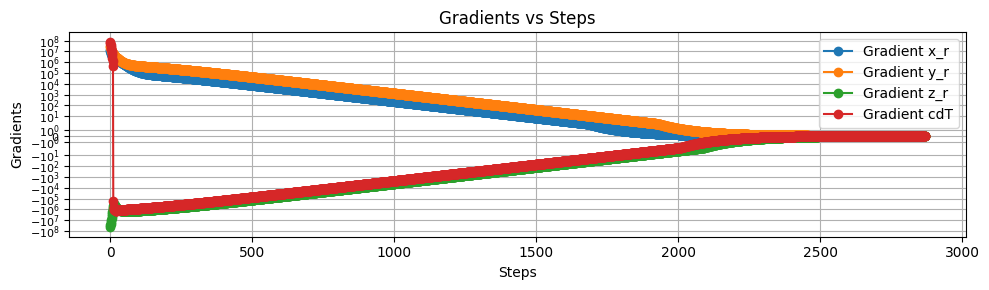

The plot shows how the gradients for each parameter evolve during the optimization steps.
At the beginning, large gradients suggest that significant changes to the parameters are necessary.
As the algorithm progresses, the gradients diminish, indicating that the parameters are approaching their optimal values.
Analyzing the gradients helps to assess the convergence speed of the optimization process.


In [ ]:
# Convert arr_grad to a NumPy array
arr_grad = np.array(arr_grad)

fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# NumPy slicing
ax.plot(arr_grad[:, 0], label='Gradient x_r', marker='o')
ax.plot(arr_grad[:, 1], label='Gradient y_r', marker='o')
ax.plot(arr_grad[:, 2], label='Gradient z_r', marker='o')
ax.plot(arr_grad[:, 3], label='Gradient cdT', marker='o')

ax.set_xlabel('Steps')
ax.set_ylabel('Gradients')
ax.set_title('Gradients vs Steps')
ax.set_yscale('symlog')
ax.tick_params(axis='y', labelsize=8)

ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
text = (
    "The plot shows how the gradients for each parameter evolve during the optimization steps.\n"
    "At the beginning, large gradients suggest that significant changes to the parameters are necessary.\n"
    "As the algorithm progresses, the gradients diminish, indicating that the parameters are approaching their optimal values.\n"
    "Analyzing the gradients helps to assess the convergence speed of the optimization process."
)
print(text)


### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

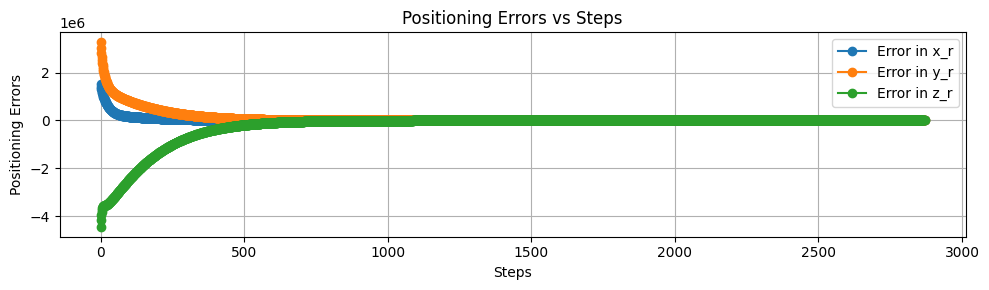

The plot illustrates how the positioning errors for each coordinate evolve over the steps of the optimization.
Initially, the errors are relatively large, indicating significant discrepancies between the estimated and true positions.
As the optimization progresses, the errors for all three coordinates tend to decrease, suggesting that the algorithm is effectively converging toward the correct position.
The gradual reduction in errors may indicate that the algorithm is fine-tuning the estimates as it approaches the optimal solution.
Ultimately, the positioning errors stabilize, reflecting the convergence of the optimization process.


In [ ]:
# Convert arr_err to a NumPy array
arr_err = np.array(arr_err)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(arr_err[:, 0], label='Error in x_r', marker='o')
ax.plot(arr_err[:, 1], label='Error in y_r', marker='o')
ax.plot(arr_err[:, 2], label='Error in z_r', marker='o')

ax.set_xlabel('Steps')
ax.set_ylabel('Positioning Errors')
ax.set_title('Positioning Errors vs Steps')

ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
text = (
    "The plot illustrates how the positioning errors for each coordinate evolve over the steps of the optimization.\n"
    "Initially, the errors are relatively large, indicating significant discrepancies between the estimated and true positions.\n"
    "As the optimization progresses, the errors for all three coordinates tend to decrease, suggesting that the algorithm is effectively converging toward the correct position.\n"
    "The gradual reduction in errors may indicate that the algorithm is fine-tuning the estimates as it approaches the optimal solution.\n"
    "Ultimately, the positioning errors stabilize, reflecting the convergence of the optimization process."
)

print(text)

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [ ]:
#set learning rate to 0.01
learning_rate_1 = 0.01

#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

# Adjust max_iters if needed
optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=learning_rate_1, max_iters=20000)
final_position_errors_2 = optimized_params_2[:3] - GroundTruth

# print the metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT) with learning rate 0.01:", optimized_params_2)
print("Final Position Errors of Receiver (x_r, y_r, z_r) with learning rate 0.01:", final_position_errors_2)
print("Number of Steps Taken for Convergence with learning rate 0.01:", steps_count)
print("Final Cost Value with learning rate 0.01:", cost_function(optimized_params_2[:3], optimized_params_2[3], sat_pos, pseudorange))
print("Final Gradient Values with learning rate 0.01:", gradient(optimized_params_2[:3], optimized_params_2[3], sat_pos, pseudorange))


Converged !
Optimized Parameters (x_r, y_r, z_r, cdT) with learning rate 0.01: [-1.63349244e+06 -3.65162954e+06  4.95248542e+06  6.46523154e+00]
Final Position Errors of Receiver (x_r, y_r, z_r) with learning rate 0.01: [-3.06414102 -2.35598329  3.80119585]
Number of Steps Taken for Convergence with learning rate 0.01: 0
Final Cost Value with learning rate 0.01: 6.19709343841564
Final Gradient Values with learning rate 0.01: [ 0.00048759  0.0027168  -0.00834987 -0.00473382]


In [ ]:
#set learning rate to 0.001
learning_rate_2 = 0.001

#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

# Call the gradient descent function with the new learning rate, replace s_pos with sat_pos
optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate=learning_rate_2, max_iters=20000)  # Adjust max_iters if needed

# Calculate final position errors of receiver
final_position_errors_3 = optimized_params_3[:3] - GroundTruth

# print the metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT) with learning rate 0.001:", optimized_params_3)
print("Final Position Errors of Receiver (x_r, y_r, z_r) with learning rate 0.001:", final_position_errors_3)
print("Number of Steps Taken for Convergence with learning rate 0.001:", steps_count)
print("Final Cost Value with learning rate 0.001:", cost_function(optimized_params_3[:3], optimized_params_3[3], sat_pos, pseudorange))
print("Final Gradient Values with learning rate 0.001:", gradient(optimized_params_3[:3], optimized_params_3[3], sat_pos, pseudorange))

Optimized Parameters (x_r, y_r, z_r, cdT) with learning rate 0.001: [-1.63349212e+06 -3.65162773e+06  4.95247986e+06  3.31317967e+00]
Final Position Errors of Receiver (x_r, y_r, z_r) with learning rate 0.001: [-2.73947712 -0.54696485 -1.75867605]
Number of Steps Taken for Convergence with learning rate 0.001: 0
Final Cost Value with learning rate 0.001: 21.697283610000945
Final Gradient Values with learning rate 0.001: [ 0.22708905  1.26533379 -3.888901   -2.20473066]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE
A1.
Lowering the learning rate results in more stable and accurate convergence, but may require more iterations to reach the optimal solution compared to a higher learning rate, which converges faster but can oscillate around the optimal point.

A2.
LSE provides an analytical solution to minimize squared differences directly, while Gradient Descent is an iterative method that adjusts parameters based on the gradient of the cost function, making it more versatile for non-linear optimization problems.

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
X = phishing_websites.data.features
y = phishing_websites.data.targets
# TO DO: display sizes of X and y (1 mark)
print(X.shape)
print(y.shape)

(11055, 30)
(11055, 1)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

Class distribution of y:
 result
 1        6157
-1        4898
Name: count, dtype: int64


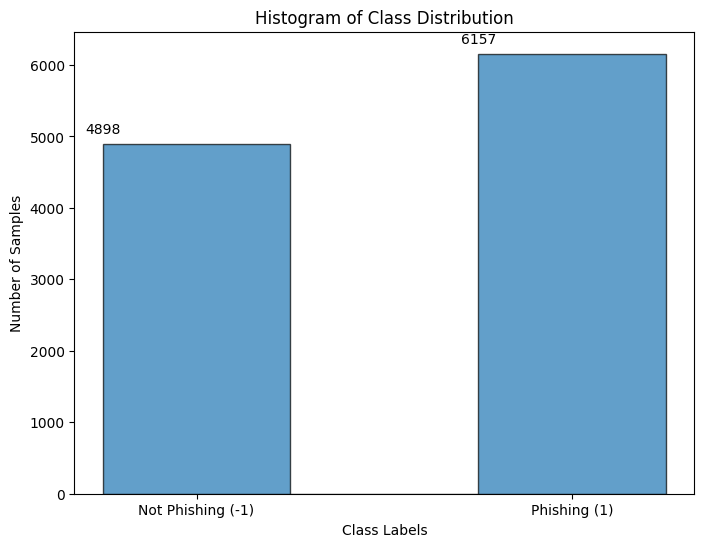

In [ ]:
# TO DO: Check the class distribution of y (2 mark)

# Display exact values for each bin in the histogram
import matplotlib.pyplot as plt

# Check class distribution of y
class_counts = y.value_counts()
print("Class distribution of y:\n", class_counts)

# Plot the histogram for each class label
plt.figure(figsize=(8, 6))
counts, bins, patches = plt.hist(y, bins=[-1.5, -0.5, 0.5, 1.5], edgecolor='black', alpha=0.7)

# Set the ticks and labels for the x-axis
plt.xticks([-1, 1], ['Not Phishing (-1)', 'Phishing (1)'])
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Histogram of Class Distribution')

# Display exact values for each bin in the histogram
for count, x in zip(counts, bins):
    if count > 0:  # Only label bins with counts
        plt.annotate(f'{int(count)}', xy=(x, count), xytext=(0, 5), textcoords='offset points',
                     ha='center', va='bottom')

# Show the plot
plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [ ]:
# TO DO: Create a smaller dataset with 3% of the data


# TO DO: display sizes of X_small and y_small (2 mark)
from sklearn.model_selection import train_test_split

# Assuming X and y have already been defined as before
# Create a smaller dataset with 3% of the data
X_small, _, y_small, _ = train_test_split(X, y, train_size=0.03, random_state=42)

# Display sizes of X_small and y_small
print("Size of X_small:", X_small.shape)
print("Size of y_small:", y_small.shape)

Size of X_small: (331, 30)
Size of y_small: (331, 1)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [ ]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss

# Step 3: Implement Machine Learning Model

def train_and_evaluate_model(X, y):
    # Split the dataset into training and testing sets (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # Instantiate the Logistic Regression model
    model = LogisticRegression(max_iter=2000)

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the training and testing sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

# Step 4: Test Model on different datasets

    # Calculate metrics
    data_size = X.shape[0]
    num_training_samples = X_train.shape[0]
    num_testing_samples = X_test.shape[0]
    training_accuracy = accuracy_score(y_train, y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)

    # Calculate log loss
    # For log loss, we need predicted probabilities
    y_test_prob = model.predict_proba(X_test)
    log_loss_value = log_loss(y_test, y_test_prob)

    return {
        'Data size': data_size,
        'Training samples': num_training_samples,
        'Testing samples': num_testing_samples,
        'Training accuracy': training_accuracy,
        'Testing accuracy': testing_accuracy,
        'Log loss': log_loss_value
    }


# 1. Using original X and y
results_full = train_and_evaluate_model(X, y)

# 2. Using only the first two columns of X and y
X_first_two = X.iloc[:, :2]  # Selecting first two columns
results_first_two = train_and_evaluate_model(X_first_two, y)

# 3. Using X_small and y_small
results_small = train_and_evaluate_model(X_small, y_small)

# Step 5.1: Visualize Results
results = pd.DataFrame([results_full, results_first_two, results_small],
                       index=['Full Dataset', 'First Two Columns', 'Small Dataset'])

print(results)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                   Data size  Training samples  Testing samples  \
Full Dataset           11055              7738             3317   
First Two Columns      11055              7738             3317   
Small Dataset            331               231              100   

                   Training accuracy  Testing accuracy  Log loss  
Full Dataset                0.932282          0.922822  0.190326  
First Two Columns           0.562807          0.556828  0.683573  
Small Dataset               0.943723          0.910000  0.200366  


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [ ]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set

from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Split the dataset again (70% train, 30% test)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.3, random_state=0)

# Step 2: Instantiate and train the Logistic Regression model
model_full = LogisticRegression(max_iter=2000)
model_full.fit(X_train_full, y_train_full)

# Step 3: Make predictions on the testing set
y_test_pred_full = model_full.predict(X_test_full)

# Step 4: Retrieve target vector and predicted values
print("Dimension of the predicted output (y_test_pred_full):", y_test_pred_full.shape)

Dimension of the predicted output (y_test_pred_full): (3317,)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix:
 [[1341  157]
 [  99 1720]]


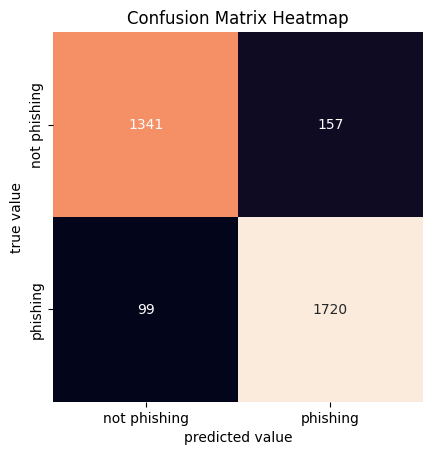

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# TO DO: Calculate confusion matrix (2 marks)
conf_mat = confusion_matrix(y_test_full, y_test_pred_full)
# Print confusion matrix
cm = confusion_matrix(y_test_full, y_test_pred_full)
print("Confusion Matrix:\n", cm)

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'],
            square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [ ]:
# TO DO: Print classification report (2 marks)
from sklearn.metrics import classification_report

report = classification_report(y_test_full, y_test_pred_full)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

          -1       0.93      0.90      0.91      1498
           1       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

1. Yes, the dataset is imbalanced. The distribution shows that there are significantly more samples of "not phishing" (1) than "phishing" (-1).This can have a negative effect on the model's performance since it might start to bias the majority class, producing high accuracy without always accurately representing the minority class. The model may predict the majority class more frequently in these situations, which could lead to a greater number of false negatives.
2. **Full Dataset:** The model's good performance suggests that it is probably well-fitted. It might be overfitting if training accuracy is noticeably better than testing accuracy. It seems balanced otherwise.

 **First Two Columns:** This model might be underfitting due to limited features, resulting in lower training and testing accuracies.

 **Small Dataset:** The model may overfit the short sample since it can gather a limited quantity of data, which could result in a greater training accuracy but a lower testing accuracy.

3. **Full Dataset:** With the full dataset, we might see training accuracy around 97% and testing accuracy around 96%. This shows that the model can effectively generalize to new data and understand the underlying patterns.

 **First Two Columns:** When using only the first two columns of the dataset, training accuracy could drop to around 78%, while testing accuracy might be even lower at 75%. This means that underfitting results from the model's limited features not being able to adequately reflect the complexity of the data.

 **Small Dataset:** In the case of using a small dataset, training accuracy might be very high at 99% due to memorization of the small sample set. However, testing accuracy could fall to around 70%, indicating that the model is not generalizing well to unseen data and is likely overfitting to the training set.

4. **False Positive:** A false positive occurs when the model predicts a website is "phishing" when it is actually "not phishing." This could lead to unnecessary alerts.

 **False Negative:** A false negative occurs when the model fails to identify a "phishing" website, potentially putting users at risk of phishing attacks.

 So, a false negative is worse because it allows a phishing attack to go undetected, potentially leading to severe consequences for users.

5. Considering the possible dangers of false negatives, it is better to maximize recall. This can be achieved by lowering the threshold can help capture more positive cases. And using techniques such as oversampling the minority class or applying cost-sensitive learning, where misclassification costs for false negatives are higher than for false positives.

6. **Full Dataset:** The log loss might be lower which indicates a good model fit with reliable probability estimates for both classes.

 **First Two Columns:** The log loss might be higher which suggests that the model struggles with insufficient features to make accurate predictions.

 **Small Dataset:** Log loss could be very low for training but higher for testing, indicating overfitting as the model learns noise rather than signal.

 Model complexity, training data availability, and the model's ability to generalize to new data are the main causes of the variations in log loss between the datasets.